This is a complementary notebook for tutorial lectures on introduction to PyTorch for [STAT8056](http://users.stat.umn.edu/~xshen/stat8056.htm), 2022 Spring. To access the slides for this tutorial, please visit [https://github.umn.edu/liu00980/STAT8056_intro_pytorch](https://github.umn.edu/liu00980/STAT8056_intro_pytorch).

In [1]:
# basic torch modules, classes and functions
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# image datasets and pre-processing
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# other utils libraries
import time
import numpy as np
import matplotlib.pyplot as plt

# Tensor

## Create tensors with gradient tracing

In [2]:
t = torch.tensor(3, dtype = float)
t.requires_grad_(True)

# or alternatively
t = torch.tensor(3.0, requires_grad = True)

In [3]:
t

tensor(3., requires_grad=True)

## Calculate and access the gradient

In [4]:
# create tensors
c = torch.tensor(1.)
t = torch.tensor(3., requires_grad = True)
print(c)
print(t)

# do your calculation based on t
s = t**2
f = 3 * s + c

# calculate the gradient w.r.t. t
f.backward()

# access the gradient
t.grad

tensor(1.)
tensor(3., requires_grad=True)


tensor(18.)

## Some MISTAKES regarding gradient and computation graph

### Call `.backward` when there is no graph (or the graph has been destroyed)

In [5]:
t = torch.tensor(3., requires_grad = True)
s = t**2
s.backward() # graph is destroyed

s.backward() # error!

RuntimeError: ignored

### Call `.grad` on non-leaf nodes

In [6]:
t = torch.tensor(3., requires_grad = True) # the leaf node
s = t**2 # the intermediate node
f = 3 * s + 1 # the objective
f.backward() 

s.grad # warning and no result

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


### Gradient accumulation

In [7]:
# first back propagation
t = torch.tensor(3., requires_grad = True)
s = t**2
s.backward()
print(t.grad)

# second propagation (WITHOUT RE-CREATING t)
f = 5 * t + 1
f.backward()
print(t.grad)

tensor(6.)
tensor(11.)


In [8]:
t.grad.zero_() # zero out the gradient
f = 5 * t + 1
f.backward()
print(t.grad)

tensor(5.)


# Tensor manipulation on GPU

## Check GPU availability

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Matrix multiplication on CPU versus GPU

In [10]:
d = 3000

# C = A B with numpy on CPU
A = np.random.rand(d, d)
B = np.random.rand(d, d)
begin = time.time()
C = A.dot(B)
print(f"CPU time (numpy): {time.time() - begin} s")

# C = A B with torch on CPU
A_t_cpu = torch.tensor(A)
B_t_cpu = torch.tensor(B)
begin = time.time()
C = torch.mm(A_t_cpu, B_t_cpu)
print(f"CPU time (torch): {time.time() - begin} s")

# C = A B with torch on GPU
# make sure GPU is available
A_t_gpu = torch.tensor(A).cuda()
B_t_gpu = torch.tensor(B).cuda()
begin = time.time()
C = torch.mm(A_t_gpu, B_t_gpu)
print(f"GPU time (torch): {time.time() - begin} s")

CPU time (numpy): 1.6032278537750244 s
CPU time (torch): 1.5308353900909424 s
GPU time (torch): 0.047821044921875 s


## Transmission time from CPU to GPU

In [11]:
d = 3000
begin = time.time()
A = torch.rand((d, d)).cuda()
B = torch.rand((d, d)).cuda()
print(f"Time from CPU to GPU: {time.time() - begin} s")
begin = time.time()
C = torch.mm(A, B)
print(f"GPU time (torch): {time.time() - begin} s")

Time from CPU to GPU: 0.1591038703918457 s
GPU time (torch): 0.009942293167114258 s


# Linear regression in PyTorch

## Linear regression --- the naive approach

In [12]:
n = 2000
x = torch.rand(n)

# create dataset with true model
a0 = 2
b0 = 1
y = a0 * x + b0

# set up optimization parameter of SGD
a = torch.rand(1, requires_grad = True)
b = torch.rand(1, requires_grad = True)
nepochs = 10
batch_size = 200
lr = 0.5

In [13]:
for epoch in range(nepochs):
  for batch in range(round(n / batch_size)):
    start = batch * batch_size
    end = start + batch_size
    # perform update on a batch
    x_batch = x[start:end]
    y_batch = y[start:end]

    # build computation graph
    y_hat = a * x_batch + b
    myloss = torch.mean((y_batch - y_hat)**2)

    # gradient calculation
    myloss.backward()

    # SGD update
    with torch.no_grad():
      a -= lr * a.grad
      b -= lr * b.grad
    
    # avoid gradient accumulation
    a.grad.zero_()
    b.grad.zero_()

  print(f"Epoch: {epoch + 1} / {nepochs}")
  print(f"MSE: {myloss: .2e}; a: {a.item():.4f}; b: {b.item():.4f}")


Epoch: 1 / 10
MSE:  1.97e-02; a: 1.5698; b: 1.2276
Epoch: 2 / 10
MSE:  5.12e-03; a: 1.7805; b: 1.1161
Epoch: 3 / 10
MSE:  1.33e-03; a: 1.8880; b: 1.0592
Epoch: 4 / 10
MSE:  3.47e-04; a: 1.9429; b: 1.0302
Epoch: 5 / 10
MSE:  9.02e-05; a: 1.9709; b: 1.0154
Epoch: 6 / 10
MSE:  2.35e-05; a: 1.9851; b: 1.0079
Epoch: 7 / 10
MSE:  6.11e-06; a: 1.9924; b: 1.0040
Epoch: 8 / 10
MSE:  1.59e-06; a: 1.9961; b: 1.0020
Epoch: 9 / 10
MSE:  4.14e-07; a: 1.9980; b: 1.0010
Epoch: 10 / 10
MSE:  1.08e-07; a: 1.9990; b: 1.0005


## Linear regression --- the PyTorch way

In [14]:
class SimpleLinear(Dataset):
    def __init__(self, n, a, b, sigma = 0):
      self.n = n
      self.x = torch.rand(n, 1)
      self.y = a * self.x + b + sigma * torch.randn(n, 1)

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# create a training model
# (cont.) also initializes a and b
mymodel = nn.Sequential(nn.Linear(1, 1))

# prepare dataset and dataloaders
mydata = SimpleLinear(n = 2000, a = 2, b = 1)
mydataloader = DataLoader(mydata, batch_size = 200)

# set up optimization with SGD
criterion = nn.MSELoss()
optimizer = optim.SGD(mymodel.parameters(), lr = 0.5)

In [15]:
nepochs = 10
for epoch in range(nepochs):
  for x_batch, y_batch in mydataloader:
    # build computation graph
    yhat = mymodel(x_batch)
    myloss = criterion(y_batch, yhat)

    # optimization
    optimizer.zero_grad() # zero out gradient
    myloss.backward() # back propagation
    optimizer.step() # updata parameters

  a = mymodel[0].weight.item()
  b = mymodel[0].bias.item()
  print(f"Epoch: {epoch + 1} / {nepochs}")
  print(f"MSE: {myloss: .2e}; a: {a:.4f}; b: {b:.4f}")

Epoch: 1 / 10
MSE:  1.62e-02; a: 1.5634; b: 1.2351
Epoch: 2 / 10
MSE:  4.09e-03; a: 1.7804; b: 1.1182
Epoch: 3 / 10
MSE:  1.03e-03; a: 1.8896; b: 1.0595
Epoch: 4 / 10
MSE:  2.61e-04; a: 1.9445; b: 1.0299
Epoch: 5 / 10
MSE:  6.61e-05; a: 1.9721; b: 1.0150
Epoch: 6 / 10
MSE:  1.67e-05; a: 1.9860; b: 1.0076
Epoch: 7 / 10
MSE:  4.23e-06; a: 1.9929; b: 1.0038
Epoch: 8 / 10
MSE:  1.07e-06; a: 1.9964; b: 1.0019
Epoch: 9 / 10
MSE:  2.71e-07; a: 1.9982; b: 1.0010
Epoch: 10 / 10
MSE:  6.84e-08; a: 1.9991; b: 1.0005


# Regression with shallow ReLU net

In [16]:
class SinData(Dataset):
    def __init__(self, n, p = 5, sigma = 0):
      self.n = n
      self.x = 2 * torch.rand(n, p) - 1
      self.x1 = self.x[:, :1]
      self.y = torch.sin(4 * self.x1) + sigma * torch.randn(n, 1)

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# initialize a training model
train_model = nn.Sequential(
    nn.Linear(5, 256), 
    nn.ReLU(),
    nn.Linear(256, 1)
)

# prepare TRAINING dataset and dataloaders 
train_data = SinData(n = 200, sigma = 0.2)
train_loader = DataLoader(train_data, batch_size = 200) # simple GD
test_data = SinData(n = 200, sigma = 0.2)
test_loader = DataLoader(test_data, batch_size = 200) # simple GD

# set up optimization with SGD
criterion = nn.MSELoss()

# WITHOUT WEIGHT DECAY
optimizer = optim.Adam(train_model.parameters(), lr = 0.001)
# # WITH WEIGHT DECAY
# optimizer = optim.Adam(train_model.parameters(), lr = 0.001, weight_decay = 0.01)

In [17]:
nepochs = 3000
for epoch in range(nepochs):
  for x_batch, y_batch in train_loader:
    # build computation graph
    yhat = train_model(x_batch)
    myloss = criterion(y_batch, yhat)

    # optimizatin
    optimizer.zero_grad() # zero out gradient
    myloss.backward() # back propagation
    optimizer.step() # updata parameters

  if epoch % 300 == 299:
    # evalulate MSE on the WHOLE traning / testing dataset
    with torch.no_grad():
      # training MSE
      y_hat_train = train_model(train_data.x)
      myloss_train = criterion(y_hat_train, train_data.y)
      # testing MSE
      x_test, y_test = next(iter(test_loader))
      y_test_hat = train_model(x_test)
      myloss_test = criterion(y_test_hat, y_test)
    print(f"Epoch: {epoch + 1} / {nepochs}; MSE (training): {myloss_train: .2e}; MSE (testing): {myloss_test: .2e}")


Epoch: 300 / 3000; MSE (training):  5.44e-02; MSE (testing):  2.89e-01
Epoch: 600 / 3000; MSE (training):  4.22e-03; MSE (testing):  1.54e-01
Epoch: 900 / 3000; MSE (training):  9.92e-04; MSE (testing):  1.47e-01
Epoch: 1200 / 3000; MSE (training):  2.69e-04; MSE (testing):  1.50e-01
Epoch: 1500 / 3000; MSE (training):  7.66e-05; MSE (testing):  1.53e-01
Epoch: 1800 / 3000; MSE (training):  2.39e-05; MSE (testing):  1.54e-01
Epoch: 2100 / 3000; MSE (training):  1.39e-05; MSE (testing):  1.56e-01
Epoch: 2400 / 3000; MSE (training):  3.35e-05; MSE (testing):  1.56e-01
Epoch: 2700 / 3000; MSE (training):  6.26e-07; MSE (testing):  1.56e-01
Epoch: 3000 / 3000; MSE (training):  7.77e-05; MSE (testing):  1.57e-01


In [18]:
# fitted value
x1_train, y_train = train_data.x1, train_data.y
x1_test, y_test = test_data.x1, test_data.y
with torch.no_grad():
  y_train_hat = train_model(train_data.x)
  y_test_hat = train_model(test_data.x)

Text(0.5, 1.0, 'True data (n = 200)')

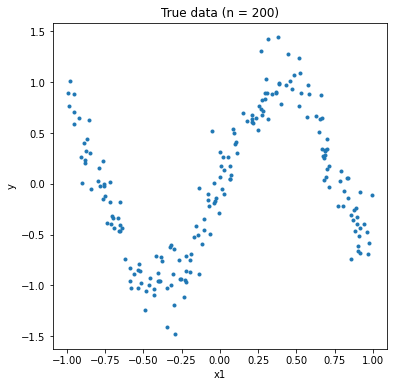

In [19]:
plt.rcParams['figure.figsize'] = [6, 6]

plt.plot(x1_train, y_train, '.')
plt.xlabel("x1")
plt.ylabel("y")
plt.title("True data (n = 200)")

Text(0.5, 1.0, 'Fitted y versus true y')

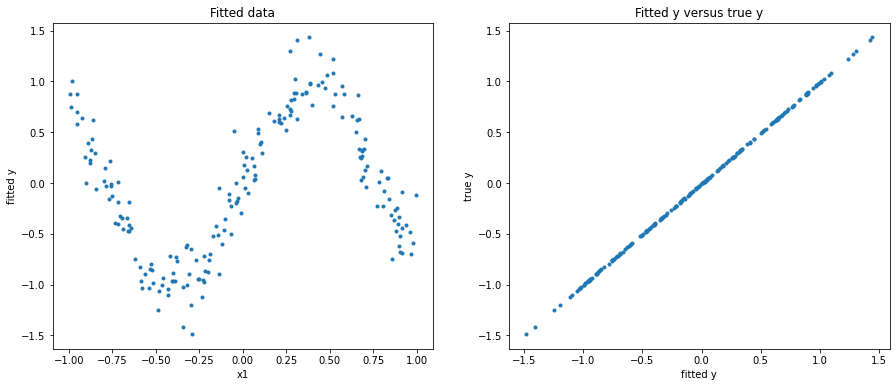

In [20]:
plt.rcParams['figure.figsize'] = [15, 6]

plt.subplot(1, 2, 1)
plt.plot(x1_train, y_train_hat, '.')
plt.xlabel("x1")
plt.ylabel("fitted y")
plt.title("Fitted data")

plt.subplot(1, 2, 2)
plt.plot(y_train, y_train_hat, '.')
plt.xlabel("fitted y")
plt.ylabel("true y")
plt.title("Fitted y versus true y")

Text(0.5, 1.0, 'Fitted y versus true y')

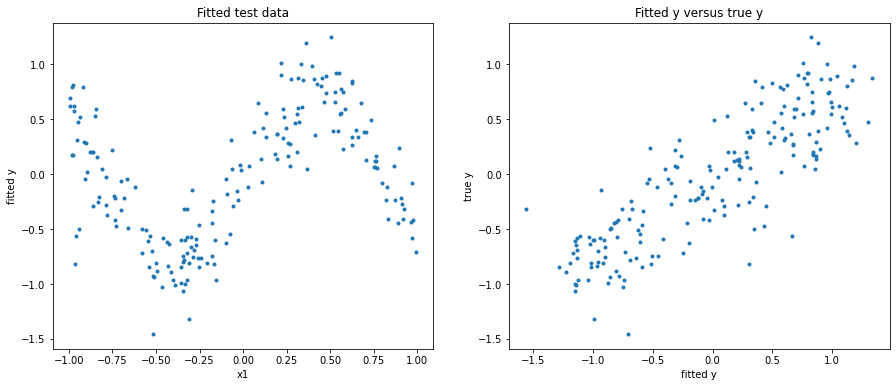

In [21]:
plt.rcParams['figure.figsize'] = [15, 6]

plt.subplot(1, 2, 1)
plt.plot(x1_test, y_test_hat, '.')
plt.xlabel("x1")
plt.ylabel("fitted y")
plt.title("Fitted test data")

plt.subplot(1, 2, 2)
plt.plot(y_test, y_test_hat, '.')
plt.xlabel("fitted y")
plt.ylabel("true y")
plt.title("Fitted y versus true y")

# Image classification with CNN

## Check GPU availability

In [22]:
# check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare datasets and data loaders

In [23]:
# define image transformation
transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                              ])

# import MNIST dataset
dataset1 = datasets.MNIST('../data', train = True, download = True, transform = transform)
dataset2 = datasets.MNIST('../data', train = False, transform = transform)

# only use 2000 training images and 20 testing images
train_index = np.random.choice(range(60000), 2000, replace = False)
test_index = np.random.choice(range(10000), 200, replace = False)
train_data = Subset(dataset1, train_index)
test_data = Subset(dataset2, test_index)

# prepare dataset loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 256)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 256)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Visualize some images

torch.Size([200, 1, 28, 28])


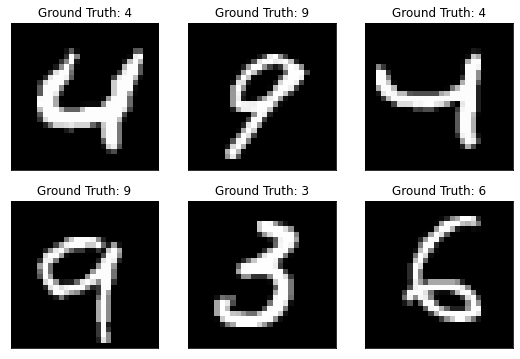

In [24]:
# visualize some digits
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

plt.rcParams['figure.figsize'] = [9, 6]
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Define CNN structure and some utils functions

In [25]:
# our CNN network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# a utils function for training
def train(model, device, train_loader, optimizer, epoch):
    model.train() # enable dropout
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # transfer batches of data to specified device
        data, target = data.to(device), target.to(device)

        # build computation graph
        output = model(data)
        loss = F.nll_loss(output, target)

        # the optimization part
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # count the corrected classified cases
        pred = output.argmax(dim = 1, keepdim = True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f"Epoch {epoch + 1}:", end = "")
    print(f" Training accuracy: {100. * correct / len(train_loader.dataset): .2f} %", end = ";")

# a utils function for evaluation on test dataset
def test(model, device, test_loader):
    model.eval() # disable dropout
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(' Testing accuracy: {}/{} ({:.0f}%)'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## Train CNN

In [26]:
# the training
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.005)

nepochs = 20
for epoch in range(nepochs):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Epoch 1: Training accuracy:  43.90 %; Testing accuracy: 167/200 (84%)
Epoch 2: Training accuracy:  80.25 %; Testing accuracy: 177/200 (88%)
Epoch 3: Training accuracy:  87.20 %; Testing accuracy: 184/200 (92%)
Epoch 4: Training accuracy:  91.75 %; Testing accuracy: 187/200 (94%)
Epoch 5: Training accuracy:  94.75 %; Testing accuracy: 188/200 (94%)
Epoch 6: Training accuracy:  95.60 %; Testing accuracy: 189/200 (94%)
Epoch 7: Training accuracy:  96.25 %; Testing accuracy: 193/200 (96%)
Epoch 8: Training accuracy:  97.40 %; Testing accuracy: 194/200 (97%)
Epoch 9: Training accuracy:  97.85 %; Testing accuracy: 193/200 (96%)
Epoch 10: Training accuracy:  97.65 %; Testing accuracy: 194/200 (97%)
Epoch 11: Training accuracy:  98.35 %; Testing accuracy: 196/200 (98%)
Epoch 12: Training accuracy:  98.15 %; Testing accuracy: 195/200 (98%)
Epoch 13: Training accuracy:  98.65 %; Testing accuracy: 193/200 (96%)
Epoch 14: Training accuracy:  98.60 %; Testing accuracy: 193/200 (96%)
Epoch 15: Train

## Evaluate CNN on digit images (written and taken from iPad, not from MNIST test dataset)

MAKE SURE you have already downloaded the `test.pkl` file from https://github.umn.edu/liu00980/STAT8056_intro_pytorch. Also, MAKE SURE you have uploaded it in Colab's current working directory.

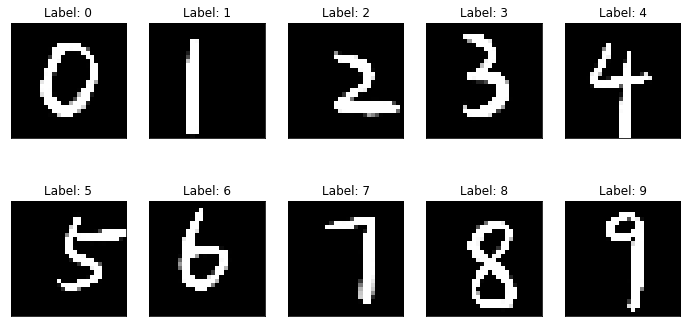

In [28]:
import pickle
testdata = pickle.load(open("test.pkl", "rb"))

# digit images (written by myself and taken from my iPad)
# (cont.) will be served as an additional test dataset to evaluate the CNN
plt.rcParams['figure.figsize'] = [12, 6]
for i in range(10):
  plt.subplot(2,5,i + 1)
  plt.imshow(testdata[i][0][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(testdata[i][1].item()))
  plt.xticks([])
  plt.yticks([])

In [29]:
# prepare dataset and dataloader for this test dataset
class myMNIST(Dataset):
    def __init__(self, dataset):
      self.sample_size = len(dataset)
      self.dataset = dataset
    
    def __len__(self):
        return self.sample_size
        
    def __getitem__(self, idx):
        return self.dataset[idx][0], self.dataset[idx][1]

mytestdataset = myMNIST(testdata)
mytestloader = DataLoader(mytestdataset, batch_size = 10)

# prediction
with torch.no_grad():
  data, target = next(iter(mytestloader))
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim = True)  # get the index of the max log-probability

Test accuracy on my own test images: 0.7


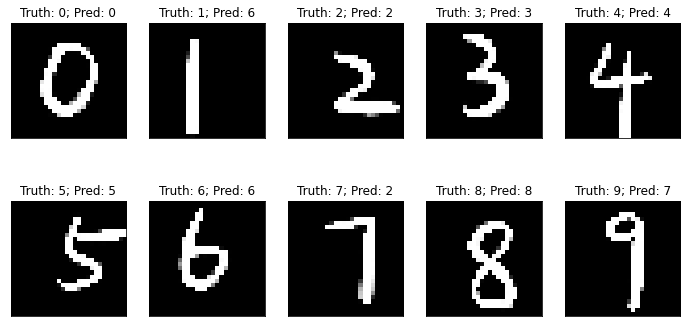

In [30]:
# visualize the prediction result
plt.rcParams['figure.figsize'] = [12, 6]
for i in range(10):
  plt.subplot(2,5,i + 1)
  plt.imshow(testdata[i][0][0], cmap='gray', interpolation='none')
  plt.title("Truth: {}; Pred: {}".format(testdata[i][1].item(), pred[i][0]))
  plt.xticks([])
  plt.yticks([])

print(f"Test accuracy on my own test images: {pred.eq(target.view_as(pred)).sum().item() / 10}")

## Model summary using pytorch-model-summary

In [31]:
# model summary
! pip install pytorch-model-summary
from pytorch_model_summary import summary
print(summary(Net(), torch.zeros((1, 1, 28, 28)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 28, 28]             320             320
          Conv2d-2     [1, 32, 26, 26]          18,496          18,496
         Dropout-3     [1, 64, 12, 12]               0               0
          Linear-4           [1, 9216]       1,179,776       1,179,776
         Dropout-5            [1, 128]               0               0
          Linear-6            [1, 128]           1,290           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
-----------------------------------------------------------------------


## Save models

### The state dictionary method

In [32]:
# save parameter values
torch.save(model.state_dict(), "model_dict.pt")

# load parameter values
model_new = Net()
model_new.load_state_dict(torch.load("model_dict.pt"))
model_new.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### The checkpoint method

In [33]:
# save checkpoint for resuming training
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "model_checkpoint.pt")

# initialize class and optimizer
model_new = Net()
optimizer_new = optim.Adam(model_new.parameters(), lr = 0.005)

# load checkpoint
checkpoint = torch.load("model_checkpoint.pt")
model_new.load_state_dict(checkpoint['model_state_dict'])
optimizer_new.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# do whatever you like :)
model_new.eval()
# - or -
model_new.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)